## Imports & Data

In [22]:
import osmnx as ox
import pandas as pd

In [23]:
rail_stations   = ox.features_from_place("London, UK",
                                         tags={"railway": "station"})
subway_entrances = ox.features_from_place("London, UK",
                                          tags={"railway": "subway_entrance"})

all_stations = pd.concat([rail_stations, subway_entrances], ignore_index=True)
all_stations.to_csv('stations.csv', index=False)

## London bivariate choropleth: Income Deprivation × Station Distance

/var/folders/lm/6244h31x0m3fg50rdw_x4c300000gp/T/ipykernel_23484/207464457.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


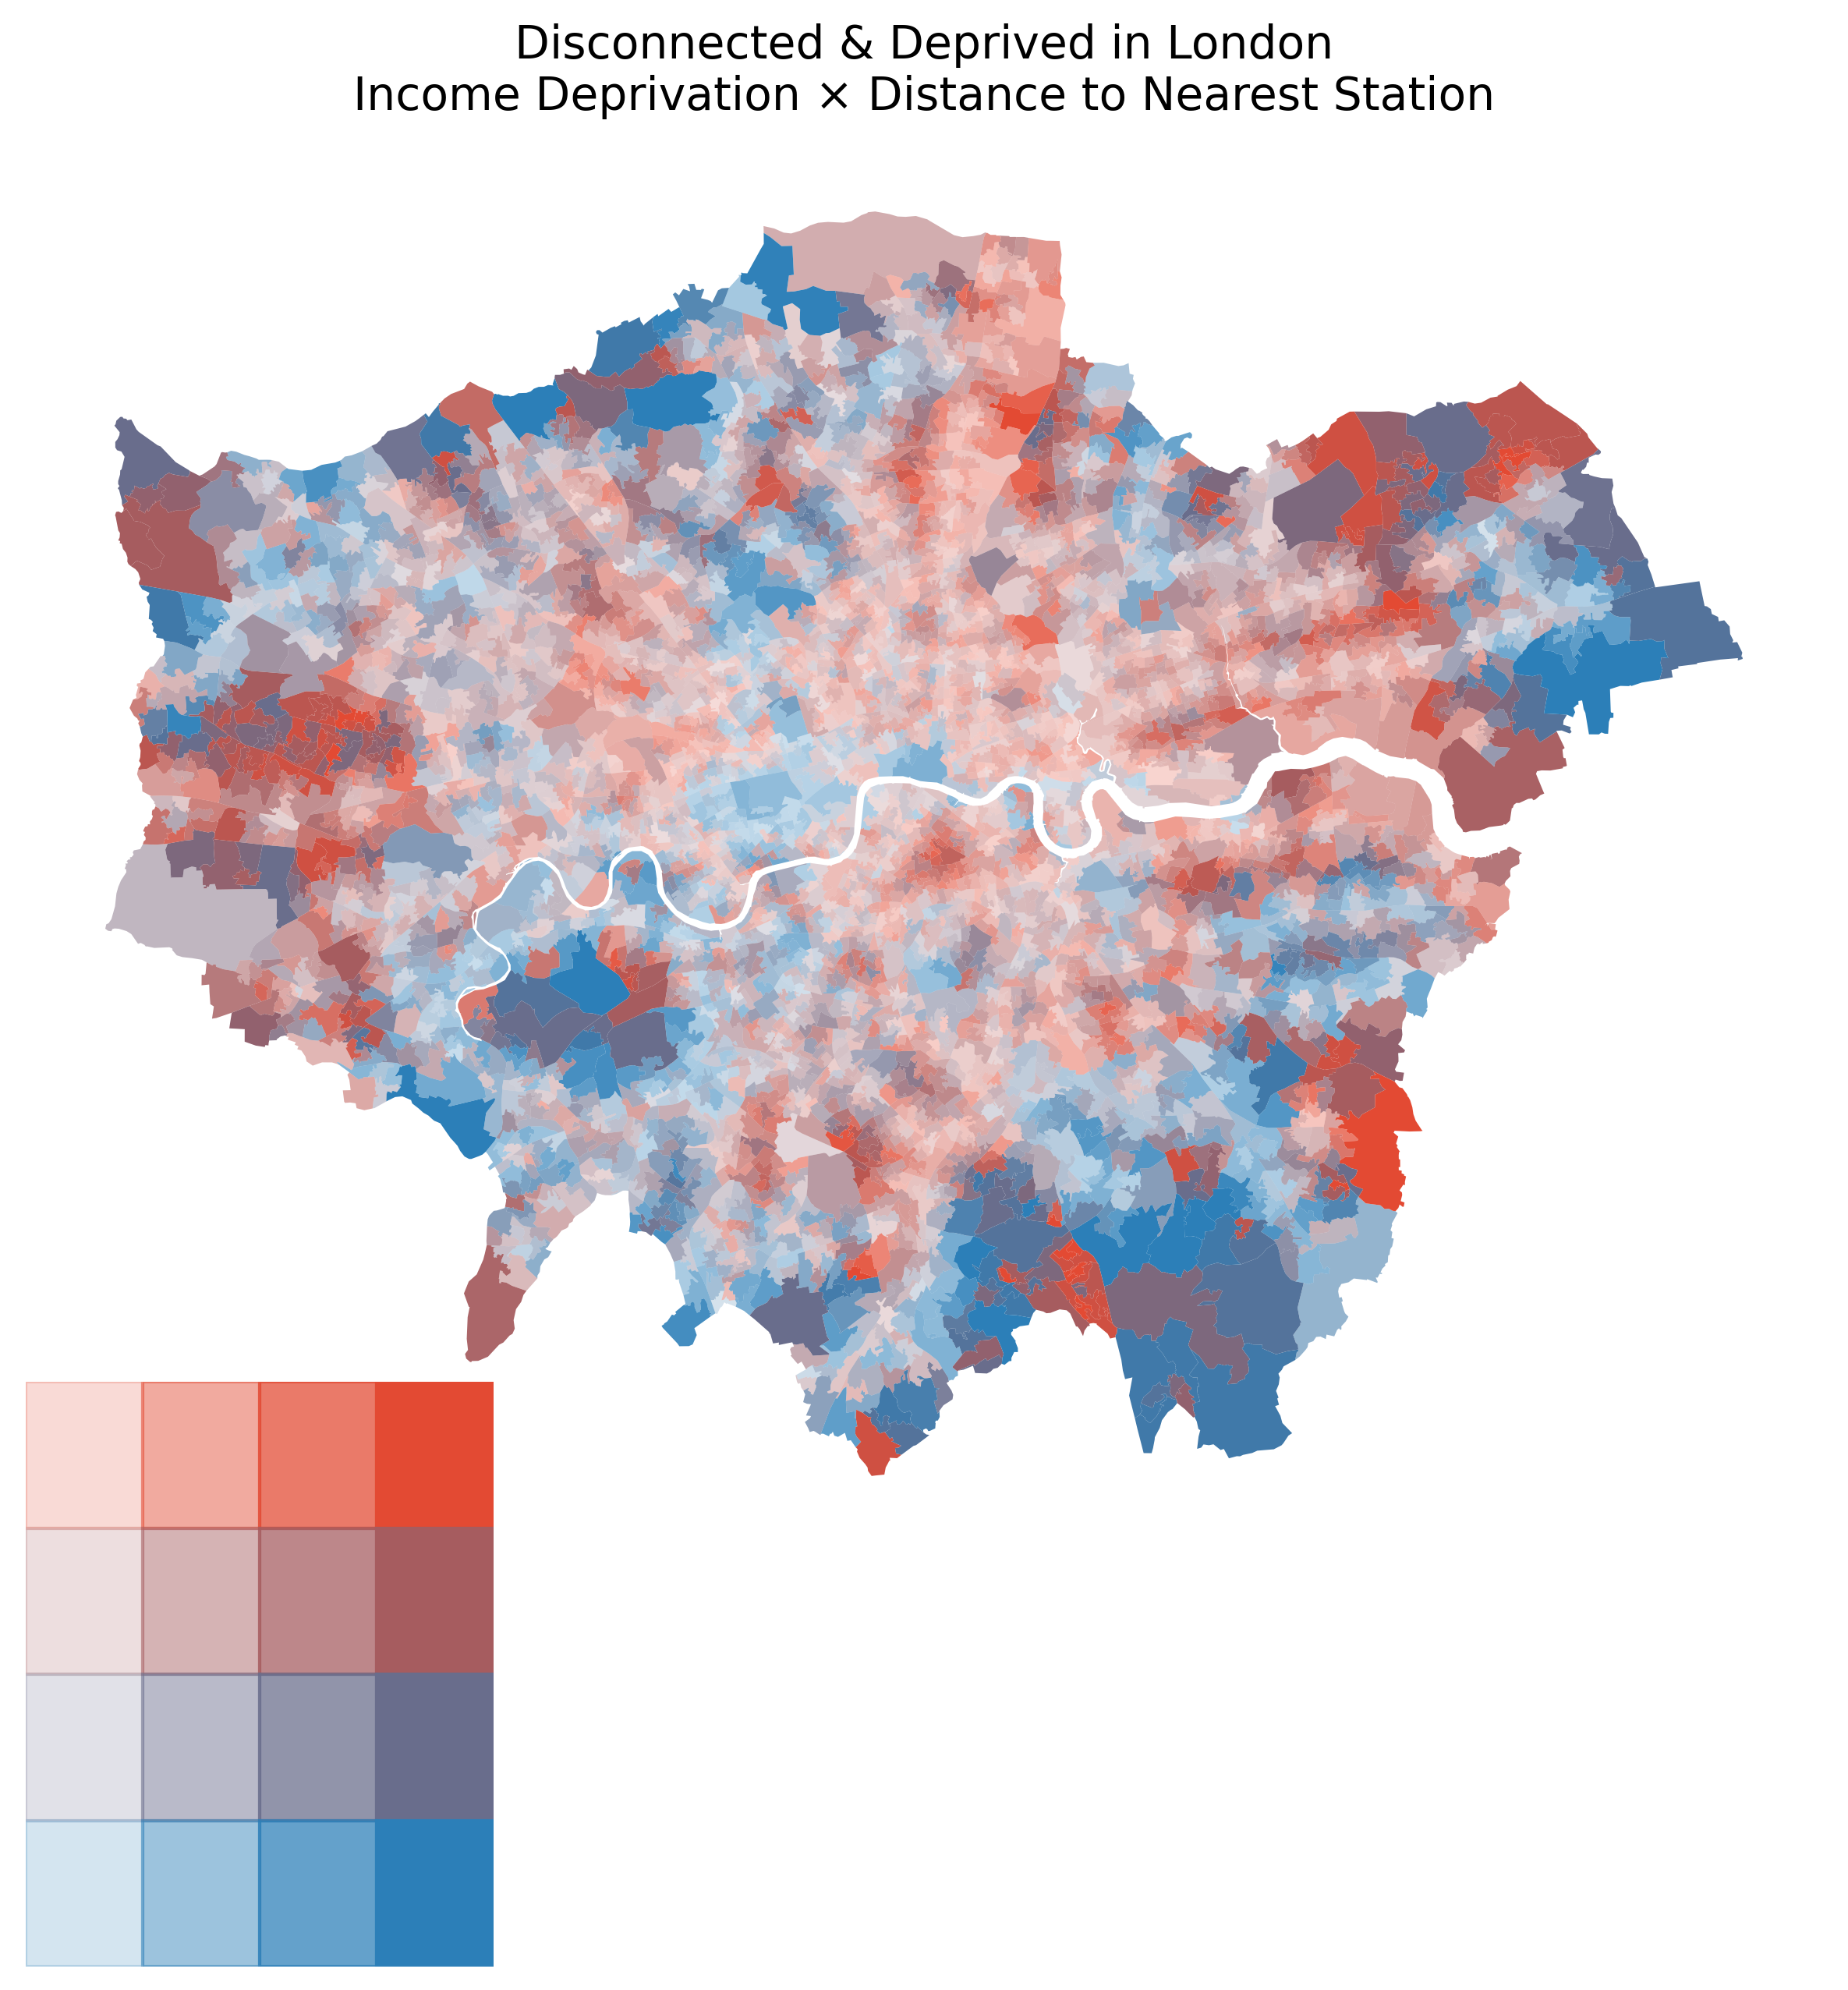

In [3]:
# ------------------------------------------------------------
# London bivariate choropleth: Income Deprivation × Station Distance
# ------------------------------------------------------------
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, to_rgba

# ----------------------------------------
# 1) READ DATA
# ----------------------------------------
# a) IoD 2019 (Income Decile + LAD code)
depr = pd.read_csv(
    "deprivation.csv",
    usecols=[
        "LSOA code (2011)",
        "Local Authority District code (2019)",   # <-- add this
        "Income Decile (where 1 is most deprived 10% of LSOAs)"
    ],
)
depr = depr.rename(
    columns={
        "LSOA code (2011)": "LSOA11CD",
        "Local Authority District code (2019)": "LAD19CD",
        "Income Decile (where 1 is most deprived 10% of LSOAs)": "income_decile",
    }
)


# b) LSOA boundaries (geometry only)
lsoas = gpd.read_file("zip://LSOA_boundaries.zip").to_crs("EPSG:27700")

# merge attributes from deprivation CSV
lsoas = lsoas.merge(depr, on="LSOA11CD", how="left")

mask = lsoas["LAD19CD"].fillna("").astype(str).str.startswith("E09")
lsoas_ldn = lsoas[mask].copy()

# c) Station locations
stations = pd.read_csv("stations.csv")

# Convert WKT geometry → GeoDataFrame
stations["geometry"] = gpd.GeoSeries.from_wkt(stations["geometry"])
stations_gdf = gpd.GeoDataFrame(stations, geometry="geometry", crs="EPSG:4326").to_crs("EPSG:27700")

stations_gdf = stations_gdf[stations_gdf.geometry.type == "Point"].copy()
stations_gdf = stations_gdf[~stations_gdf.geometry.is_empty & stations_gdf.geometry.notnull()]

# Optional: drop obvious duplicates (same name, same coords)
stations_gdf = stations_gdf.drop_duplicates(subset=["name", "geometry"])

# ----------------------------------------
# 2) NEAREST-STATION DISTANCE (km)
# ----------------------------------------
# Build KD-tree of station coords
sta_xy = np.vstack([stations_gdf.geometry.x, stations_gdf.geometry.y]).T
tree   = cKDTree(sta_xy)

# Query centroids
centroids   = lsoas_ldn.geometry.centroid
lsoa_xy     = np.vstack([centroids.x, centroids.y]).T
dist_m, _   = tree.query(lsoa_xy, k=1)
lsoas_ldn["dist_km"] = dist_m / 1000.0

# ----------------------------------------
# 3) NORMALISE BOTH AXES → [0,1]
# ----------------------------------------
# Income: 1 (red) … 10 (blue)
lsoas_ldn["income_norm"] = (lsoas_ldn["income_decile"] - 1) / 9

# Distance: clip at 2-km 95th-percentile to damp outliers
clip_km = lsoas_ldn["dist_km"].quantile(0.95)
lsoas_ldn["dist_norm"] = (lsoas_ldn["dist_km"] / clip_km).clip(0, 1)

# ----------------------------------------
# 4) MAKE RGBA COLOUR: hue = red→blue, alpha = 0.2→1
# ----------------------------------------
cmap_rb = LinearSegmentedColormap.from_list("red_blue", ["#e34a33", "#2c7fb8"])

def make_rgba(row):
    r, g, b, _ = cmap_rb(row["income_norm"])
    alpha      = 0.2 + 0.8 * row["dist_norm"]   # 0.2 (near) … 1 (far)
    return (r, g, b, alpha)

lsoas_ldn["rgba"] = lsoas_ldn.apply(make_rgba, axis=1)

# ----------------------------------------
# 5) PLOT MAP
# ----------------------------------------
fig, ax = plt.subplots(figsize=(8, 10), dpi=300)
lsoas_ldn.plot(color=lsoas_ldn["rgba"], linewidth=0, ax=ax)
ax.set_title("Disconnected & Deprived in London\nIncome Deprivation × Distance to Nearest Station",
             fontsize=14, pad=12)
ax.axis("off")

# ----------------------------------------
# 6) MINI 4×4 LEGEND (income rows, distance cols)
# ----------------------------------------
legend_ax = fig.add_axes([0.02, 0.02, 0.25, 0.25])  # [left, bottom, width, height]
legend_ax.axis("off")
n = 4
for i in range(n):              # income (rows)
    for j in range(n):          # distance (cols)
        income_norm = i/(n-1)   # 0 … 1
        dist_norm   = j/(n-1)
        r, g, b, _  = cmap_rb(income_norm)
        alpha       = 0.2 + 0.8*dist_norm
        legend_ax.add_patch(
            plt.Rectangle((j, n-1-i), 1, 1, color=(r, g, b, alpha))
        )

# Tick labels
legend_ax.set_xticks([0.5, n-1.5])
legend_ax.set_xticklabels(["Near\nstation", "Far"])
legend_ax.set_yticks([0.5, n-1.5])
legend_ax.set_yticklabels(["Most\ndeprived", "Least"])
legend_ax.set_xlim(0, n)
legend_ax.set_ylim(0, n)

plt.tight_layout()
plt.savefig("london_bivariate_imd_station.png", bbox_inches="tight")
plt.show()


## London bivariate choropleth Income Deprivation × Station Distance (Interactive)

In [2]:
# ------------------------------------------------------------
# London bivariate choropleth (Income Deprivation × Station Distance)
# → interactive Folium map using TopoJSON (no seams, no parks)
# ------------------------------------------------------------
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from scipy.spatial import cKDTree
from matplotlib.colors import LinearSegmentedColormap
import folium
from folium.plugins import MousePosition
from folium.features import TopoJson
from topojson import Topology

# ----------------------------------------
# 1) READ & PREP DATA
# ----------------------------------------

# a) Income Deprivation (IoD 2019)
depr = (
    pd.read_csv(
        "deprivation.csv",
        usecols=[
            "LSOA code (2011)",
            "Local Authority District code (2019)",
            "Income Decile (where 1 is most deprived 10% of LSOAs)",
        ],
    )
    .rename(
        columns={
            "LSOA code (2011)": "LSOA11CD",
            "Local Authority District code (2019)": "LAD19CD",
            "Income Decile (where 1 is most deprived 10% of LSOAs)": "income_decile",
        }
    )
)

# b) LSOA boundaries
lsoas = (
    gpd.read_file("zip://LSOA_boundaries.zip")
    .to_crs("EPSG:27700")
    .merge(depr, on="LSOA11CD", how="left")
)

lsoas_ldn = (
    lsoas[lsoas["LAD19CD"].fillna("").astype(str).str.startswith("E09")]
    .copy()
    .reset_index(drop=True)
)

# c) Station locations
stations = pd.read_csv("stations.csv")
stations["geometry"] = gpd.GeoSeries.from_wkt(stations["geometry"])
stations_gdf = (
    gpd.GeoDataFrame(stations, geometry="geometry", crs="EPSG:4326")
    .to_crs("EPSG:27700")
)
stations_gdf = (
    stations_gdf[
        (stations_gdf.geometry.type == "Point")
        & stations_gdf.geometry.notnull()
        & ~stations_gdf.geometry.is_empty
    ]
    .drop_duplicates(subset=["name", "geometry"])
)

# ----------------------------------------
# 2) DISTANCE TO NEAREST STATION
# ----------------------------------------
tree = cKDTree(np.vstack([stations_gdf.geometry.x, stations_gdf.geometry.y]).T)
centroids = lsoas_ldn.geometry.centroid
lsoas_ldn["dist_km"] = (
    tree.query(np.vstack([centroids.x, centroids.y]).T, k=1)[0] / 1000.0
)

# ----------------------------------------
# 3) BIVARIATE COLOUR
# ----------------------------------------
lsoas_ldn["income_norm"] = (lsoas_ldn["income_decile"] - 1) / 9
clip_km = lsoas_ldn["dist_km"].quantile(0.95)
lsoas_ldn["dist_norm"] = (lsoas_ldn["dist_km"] / clip_km).clip(0, 1)

cmap_rb = LinearSegmentedColormap.from_list("red_blue", ["#e34a33", "#2c7fb8"])
lsoas_ldn["rgba"] = lsoas_ldn.apply(
    lambda r: (*cmap_rb(r.income_norm)[:3], 0.2 + 0.8 * r.dist_norm),
    axis=1,
)

# ► light simplification (10 m) – TopoJSON will preserve shared edges exactly
lsoas_ldn["geometry"] = lsoas_ldn.geometry.simplify(
    10, preserve_topology=True
)

# add explicit index property for styling lookup
lsoas_ldn["idx"] = lsoas_ldn.index.astype(int)

# ----------------------------------------
# 4) CONVERT TO TOPOJSON (in-memory)
# ----------------------------------------
lsoas_4326 = lsoas_ldn.to_crs("EPSG:4326")
topojson_data = Topology(lsoas_4326, prequantize=False).to_dict()
first_obj = next(iter(topojson_data["objects"]))      # usually 'data'
object_path = f"objects.{first_obj}"

# ----------------------------------------
# 5) BUILD FOLIUM MAP
# ----------------------------------------
m = folium.Map(
    location=[51.509, -0.118],
    zoom_start=9,
    tiles="CartoDB Positron",
)

def style_fn(feat):
    idx = int(feat["id"])
    r, g, b, a = lsoas_ldn.loc[idx, "rgba"]
    fill = f"#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}"
    return {
        "fillColor":  fill,
        "fillOpacity": a,
        "color":       fill,   # same colour → seamless
        "weight":      1,    # sub-pixel hairline
        "opacity":     a,      # line opacity matches fill
    }

TopoJson(
    topojson_data,
    object_path,
    name="LSOA IMD × Distance",
    style_function=style_fn,
    tooltip=folium.GeoJsonTooltip(
        fields=["LSOA11CD", "income_decile", "dist_km"],
        aliases=["LSOA", "Income decile", "Dist. km"],
        sticky=False,
    ),
).add_to(m)

MousePosition(position="bottomright").add_to(m)
folium.LayerControl(collapsed=True).add_to(m)

m.save("london_bivariate_interactive.html")
print("✅  Saved → london_bivariate_interactive.html  (Topologically seam-free)")

✅  Saved → london_bivariate_interactive.html  (Topologically seam-free)


In [3]:
# Count how many London LSOA districts we have
num_lsoas = lsoas_ldn["LSOA11CD"].nunique()
print(f"Number of LSOA districts in London: {num_lsoas}")

Number of LSOA districts in London: 4835


In [6]:
# ------------------------------------------------------------
# How many LSOA districts lie within 50 km of (Greater) London?
# ------------------------------------------------------------
import geopandas as gpd

# 1) Get a single polygon for Greater London and its centroid
london_polygon  = lsoas_ldn.unary_union          # dissolves all London LSOAs
london_centroid = london_polygon.centroid        # Point in EPSG:27700

# 2) Compute distance from that point to *all* LSOA centroids
lsoas["centroid"] = lsoas.geometry.centroid      # lsoas was the full national file
lsoas["dist_km"]  = lsoas["centroid"].distance(london_centroid) / 1000.0

# 3) Filter and count
within_50 = lsoas[lsoas["dist_km"] <= 50]
n_within  = within_50["LSOA11CD"].nunique()

print(f"LSOA districts ≤ 50 km of London: {n_within}")

/var/folders/lm/6244h31x0m3fg50rdw_x4c300000gp/T/ipykernel_61088/1529790822.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  london_polygon  = lsoas_ldn.unary_union          # dissolves all London LSOAs


LSOA districts ≤ 50 km of London: 7700


## London commute duration map

In [51]:
import os, time
from datetime import datetime
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from traveltimepy import Client
from traveltimepy.requests.common import Location, Coordinates, Property
from traveltimepy.requests.time_filter import TimeFilterArrivalSearch
from traveltimepy.requests.transportation import PublicTransport
from dotenv import load_dotenv
import folium, branca
from folium.features import TopoJson
from folium.plugins import MousePosition
from topojson import Topology

In [52]:
load_dotenv()
client = Client(app_id=os.getenv("TT_APP_ID"),
                api_key=os.getenv("TT_API_KEY"))

In [53]:
DEST_LAT, DEST_LON = 51.51419, -0.13501
dest_loc = Location(id="wardour",
                    coords=Coordinates(lat=DEST_LAT, lng=DEST_LON))

lsoas = gpd.read_file("zip://LSOA_boundaries.zip").to_crs("EPSG:27700")
dest_pt = gpd.GeoSeries([Point(DEST_LON, DEST_LAT)], crs="EPSG:4326") \
             .to_crs("EPSG:27700").iloc[0]
cand = (lsoas[lsoas.centroid.within(dest_pt.buffer(100_000))]
        .copy()
        .reset_index(drop=True))
cand["idx"] = cand.index

In [54]:
origins = [
    Location(id=f"o{row.idx}",
             coords=Coordinates(lat=row.geometry.centroid.y,
                                lng=row.geometry.centroid.x))
    for row in cand.to_crs("EPSG:4326").itertuples()
]
def chunks(seq, n=2000):
    for i in range(0, len(seq), n): yield seq[i:i+n]

In [55]:
results = []
for batch in chunks(origins):
    search = TimeFilterArrivalSearch(
        id="wardour_arrival",
        arrival_location_id="wardour",
        departure_location_ids=[loc.id for loc in batch],
        arrival_time=datetime(2025, 7, 29, 9, 0),   #  ← arrive BY 09:00
        transportation=PublicTransport(),
        travel_time=120*60,                         # API cap = 120 min
        properties=[Property.TRAVEL_TIME],
    )
    resp = client.time_filter(
        locations=[dest_loc] + batch,
        arrival_searches=[search],
        departure_searches=[],
    )
    for loc in resp.results[0].locations:
        idx = int(loc.id[1:])
        minutes = loc.properties[0].travel_time/60
        results.append((idx, minutes))
    time.sleep(1)

cand = cand.merge(pd.DataFrame(results, columns=["idx", "pt_minutes"]),
                  on="idx", how="left")

In [56]:
breaks  = list(range(0, 121, 15))              # 0,15,…120
palette = [
    "#1b5e20",  # dark green
    "#388e3c",  # mid dark green
    "#66bb6a",  # mid light green
    "#a5d6a7",  # light green
    "#fff176",  # yellow
    "#ffb74d",  # yellow-orange
    "#fb8c00",  # orange
    "#e64a19",  # orange-red
]
nan_hex = "#d9d9d9"
alpha   = 0.75                                  # 75 % opacity

def pick_hex(v):
    if pd.isna(v): return nan_hex
    idx = min(max(int(v // 15), 0), 7)          # 0-7 palette index
    return palette[idx]

cand["fill"]  = cand["pt_minutes"].apply(pick_hex)
cand["rgba"]  = cand["fill"].apply(
    lambda h: tuple(int(h.lstrip("#")[i:i+2],16)/255 for i in (0,2,4)) + (alpha,)
)

In [57]:
topo = Topology(cand.to_crs("EPSG:4326"), prequantize=False).to_dict()
obj_path = f"objects.{next(iter(topo['objects']))}"

m = folium.Map([DEST_LAT, DEST_LON], zoom_start=8, tiles="CartoDB Positron")

def style_fn(f):
    idx = int(f["properties"]["idx"])
    r, g, b, a = cand.loc[idx, "rgba"]
    hexcol = f"#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}"
    return dict(fillColor=hexcol, fillOpacity=a, color=hexcol,
                weight=0.5, opacity=a)

TopoJson(
    topo, obj_path, name="PT minutes",
    style_function=style_fn,
    tooltip=folium.GeoJsonTooltip(
        fields=["LSOA11CD","pt_minutes"],
        aliases=["LSOA","PT minutes"],
        sticky=False),
).add_to(m)

folium.Marker([DEST_LAT, DEST_LON],
              tooltip="Wardour St (dest)",
              icon=folium.Icon(color="blue", icon="train", prefix="fa")).add_to(m)

In [58]:
legend = branca.colormap.StepColormap(
    colors=palette,
    vmin=0, vmax=120, index=breaks,
    caption="Public-transport minutes\n(arrive by 09:00)")
legend_html = legend._repr_html_().replace(
    "<div style=", "<div style='opacity:0.9;'")  # slight transparency
m.get_root().html.add_child(folium.Element(legend_html))

MousePosition(position="bottomright").add_to(m)
folium.LayerControl(collapsed=True).add_to(m)

m.save("london_commute_pt_100km_15min.html")
print("🗺️  Saved → london_commute_pt_100km_15min.html")

🗺️  Saved → london_commute_pt_100km_15min.html
